In [1]:
# @title Import Library
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
from google.colab import drive
drive.mount('/content/drive/')
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV,KFold,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

Mounted at /content/drive/


## Feature Enginering

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab minipro 4 /Permodelan data Home Credit Indonesia/Data HCI/application_train.csv')
print('Jumlah data:', train.shape)
print('Jumlah Missing value :',(train.isnull().sum()/len(train)*100))
print('Jumlah Data Duplikat :',train['SK_ID_CURR'].duplicated().sum())
# Total data yang dimiliki 307.511 baris dan 122 feature termasuk target
# Berdasarkan hasil tidak terdapat data duplikat pada data SK_ID_CURR ini
# menunjukan data perbaris mewakili 1 user. Terdapat banyak data missing, dengan
# begitu saya akan melakukan beberapa metode untuk menghandle data missing

Jumlah data: (307511, 122)
Jumlah Missing value : SK_ID_CURR                       0.000000
TARGET                           0.000000
NAME_CONTRACT_TYPE               0.000000
CODE_GENDER                      0.000000
FLAG_OWN_CAR                     0.000000
FLAG_OWN_REALTY                  0.000000
CNT_CHILDREN                     0.000000
AMT_INCOME_TOTAL                 0.000000
AMT_CREDIT                       0.000000
AMT_ANNUITY                      0.003902
AMT_GOODS_PRICE                  0.090403
NAME_TYPE_SUITE                  0.420148
NAME_INCOME_TYPE                 0.000000
NAME_EDUCATION_TYPE              0.000000
NAME_FAMILY_STATUS               0.000000
NAME_HOUSING_TYPE                0.000000
REGION_POPULATION_RELATIVE       0.000000
DAYS_BIRTH                       0.000000
DAYS_EMPLOYED                    0.000000
DAYS_REGISTRATION                0.000000
DAYS_ID_PUBLISH                  0.000000
OWN_CAR_AGE                     65.990810
FLAG_MOBIL                

In [3]:
# @title Handle Missing Value
# Saya akan melakukan fillna dengan menggunakan nilai median data feature itu
# sendiri untuk mengurangi nilai Outlier dari pengunakan mean. Dan saya akan
# menggunakan modus untuk feature kaegorikal dan value tertentu tergantung pada
# kondisi feature itu sendiri
train['AMT_ANNUITY'] = train['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].median())
train['AMT_GOODS_PRICE'] = train['AMT_GOODS_PRICE'].fillna(train['AMT_GOODS_PRICE'].median())
train['NAME_TYPE_SUITE'] = train['NAME_TYPE_SUITE'].fillna(train['NAME_TYPE_SUITE'].mode()[0])
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].fillna(0)
train['OCCUPATION_TYPE'] = train['OCCUPATION_TYPE'].fillna('None') # * lakukan Pengelompokan untuk mengurangi dimensi ketika dilakukan label encoding
train['EXT_SOURCE_1'] = train['EXT_SOURCE_1'].fillna(0)
train['EXT_SOURCE_2'] = train['EXT_SOURCE_2'].fillna(0)
train['EXT_SOURCE_3'] = train['EXT_SOURCE_3'].fillna(0)
train['OBS_30_CNT_SOCIAL_CIRCLE'] = train['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0)
train['DEF_30_CNT_SOCIAL_CIRCLE'] = train['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0)
train['OBS_60_CNT_SOCIAL_CIRCLE'] = train['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0)
train['DEF_60_CNT_SOCIAL_CIRCLE'] = train['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)
train['DAYS_LAST_PHONE_CHANGE'] = train['DAYS_LAST_PHONE_CHANGE'].fillna(train['DAYS_LAST_PHONE_CHANGE'].median())
train['AMT_REQ_CREDIT_BUREAU_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(train['AMT_REQ_CREDIT_BUREAU_YEAR'].median())
train['AMT_REQ_CREDIT_BUREAU_HOUR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(train['AMT_REQ_CREDIT_BUREAU_HOUR'].median())
train['AMT_REQ_CREDIT_BUREAU_DAY'] = train['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(train['AMT_REQ_CREDIT_BUREAU_DAY'].median())
train['AMT_REQ_CREDIT_BUREAU_WEEK'] = train['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(train['AMT_REQ_CREDIT_BUREAU_WEEK'].median())
train['AMT_REQ_CREDIT_BUREAU_MON'] = train['AMT_REQ_CREDIT_BUREAU_MON'].fillna(train['AMT_REQ_CREDIT_BUREAU_MON'].median())
train['AMT_REQ_CREDIT_BUREAU_QRT'] = train['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(train['AMT_REQ_CREDIT_BUREAU_QRT'].median())
train['CNT_FAM_MEMBERS'] = train['CNT_FAM_MEMBERS'].fillna(train['CNT_FAM_MEMBERS'].median())
train = train[train['CODE_GENDER'] != 'XNA']

In [4]:
# @title Label Encoder and Data Cleaning
# Membuat feature baru untuk mempermudah saat akan dilakukan label encoding,
# mengurangi bias dari efek labeling.
train['GROUPING_OCCUPATION_TYPE'] = train['OCCUPATION_TYPE'].replace({'Managers':'High Skill', 'High skill tech staff':'High Skill' ,
                                                                      'Accountants':'High Skill' ,'Medicine staff':'High Skill' ,'IT staff':'High Skill',
                                                                      'Core staff':'Middle Skill' ,'Sales staff':'Middle Skill','Security staff':'Middle Skill',
                                                                      'Cooking staff':'Middle Skill','Private service staff':'Middle Skill',
                                                                      'Realty agents':'Middle Skill','HR staff':'Middle Skill','Laborers':'Low Skill',
                                                                      'Drivers':'Low Skill','Cleaning staff':'Low Skill','Low-skill Laborers':'Low Skill',
                                                                      'Waiters/barmen staff':'Low Skill','Secretaries':'Low Skill','None':'None'})
train['GROUP_OCCUPATION_TYPE'] =train['GROUPING_OCCUPATION_TYPE'] .replace({'None':0,'Low Skill':1,'Middle Skill':2,'High Skill':3}).astype(int)
train['TOTAL_EXT_SOURCES'] = train['EXT_SOURCE_1'] + train['EXT_SOURCE_2'] + train['EXT_SOURCE_3']

# menghapus feature yang memiliki missing value diatas 15 % dan feature yang
# tidak diperlukan
col_drop =['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
            'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG',
            'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE',
            'COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE',
            'LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI',
            'YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI',
            'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE',
            'EMERGENCYSTATE_MODE']
train.drop(columns=col_drop, inplace=True)


In [5]:
# cross cek feature yang memiliki value hanya 1
satu_value = [col for col in train.columns if train[col].nunique()==1]
print(satu_value)

[]


In [6]:
# memeriksa data yang memiliki value yang salah berdasarkan target
employ = train[train['DAYS_EMPLOYED']==365243]
employ['TARGET'].value_counts()

TARGET
0    52384
1     2990
Name: count, dtype: int64

In [7]:
# dikarenakan pada feature days_employed terdapat value 365243 yang jika kita
# ubah dalam hitungan tau merupakan 1000 tahun lebih. Hal ini tidaklah masuk akal
# karena dalam rekor dunia durasi paling lama seseorang bekerja adalah 80 tahun,
# rata-rata kisaran diindonesia durasi paling lama orang bekerja hanya 30-40
# tahun. Oleh sebab itu maka saya akan mengambil nilai median antara 30 sampai
# 40 tahun yaitu 35 tahun untuk mengganti kesalahan inputan.
# Dan berdasarkan analisa Feature target dapat dilihat bahwa lebih banyak yang
# Current dengan feature DAY_EMPLOYED yang memiliki inputan 365243, ini
# bisa jadi indikator untuk menunjukan bahwa orang yang memiliki durasi kerja
# paling lama merupakan client yang memiliki sistem keuangan yang baik.
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace(365243.0, -12775)
cols = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION']
tahun_2018 = pd.to_datetime('2018-12-31')

for col in cols:
  train[col] = tahun_2018 + pd.to_timedelta(train[col], unit='d')

train['AGE'] = ((tahun_2018 - train['DAYS_BIRTH']).dt.days/365).round(0)
train['REGISTRATION_TIME'] = ((tahun_2018 - train['DAYS_REGISTRATION']).dt.days/365).round(0)
train['DURATION_WORK'] = ((tahun_2018 - train['DAYS_EMPLOYED']).dt.days/365).round(0)

train.drop(columns=cols, inplace= True)

In [8]:
# Cross cek feature age, registration dam work duration apakah terdapat
# nilai desimal dibelakang koma bukan bernilai 0
def check_values(df, columns):
  result={}
  for col in columns:
    result[col] = df[(df[col]>1) % 1 !=0][col].tolist()
  return result

columns_to_check = ['AGE', 'REGISTRATION_TIME', 'DURATION_WORK']
result = check_values(train, columns_to_check)

# Mengubah type data
train['AGE']=  train['AGE'].astype(int)
train['REGISTRATION_TIME']= train['REGISTRATION_TIME'].astype(int)
train['DURATION_WORK']= train['DURATION_WORK'].astype(int)

# Print the result
print('AGE:', result['AGE'])
print('REGISTRATION TIME:', result['REGISTRATION_TIME'])
print('WORK_DURATION:', result['DURATION_WORK'])

AGE: []
REGISTRATION TIME: []
WORK_DURATION: []


In [9]:
# Memperbaiki value yang salah dan melakukan Mapping (Labeling Manual)
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace({'N':0,'Y':1}).astype(int)
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace({'N':0,'Y':1}).astype(int)
train['WEEKDAY_APPR_PROCESS_START'] = train['WEEKDAY_APPR_PROCESS_START'].replace({'SUNDAY':0,'MONDAY':1,'TUESDAY':2, 'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':6}).astype(int)
train['EDUCATION'] = train['NAME_EDUCATION_TYPE'].replace({'Lower secondary': 0, 'Secondary / secondary special': 1, 'Incomplete higher': 3, 'Higher education': 2, 'Academic degree':4}).astype(int)
train['MARITAL_sTATUS'] = train['NAME_FAMILY_STATUS'].replace({'Married':'Married','Civil marriage':'Married','Single / not married':'Single','Separated':'Separated','Widow':'Separated', 'Unknown':'Unknown'})
train['MARITAL_STATUS'] = train['MARITAL_sTATUS'].replace({'Married':1,'Single':0,'Separated':2,'Unknown':3}).astype(int)
train.drop(columns=['MARITAL_sTATUS','GROUPING_OCCUPATION_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS'], inplace=True)

In [10]:
# @title Label Encoder
# melakukan Label Encoder
col = ['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE']
Label = LabelEncoder()
train[col] = train[col].apply(Label.fit_transform)

In [11]:
# @title OneHot Encoder
# melakukan OneHot Encoder
ohe = OneHotEncoder()
col = ['NAME_CONTRACT_TYPE','CODE_GENDER']
encod = ohe.fit_transform(train[col]).toarray()
encod_df = pd.DataFrame(encod, columns=ohe.get_feature_names_out(col))
train.drop(columns=col, inplace=True)
train = pd.concat([train, encod_df], axis=1)
train.dropna(inplace=True)

In [12]:
# terdapat sekitar 20 feature berisi kepemilikan dokument tertentu dalam
# value binner. Saya akan melakukan penggabungan ke 20 feature tersebut tanpa
# menghilangkan insight yaitu menggunakan PCA, agar mengurangi noise dari
# banyaknya feature
cols =['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
pca = PCA(n_components=1)
pca_resul =pca.fit_transform(train[cols])
pca_result = pd.DataFrame(pca_resul ,columns=['PCA_DOCUMENT'])
trainn = pd.concat([train,pca_result],axis=1)
trainn.drop(columns=cols, inplace=True)

In [13]:
# @title Standarisasi
scale =StandardScaler()
a_train = trainn.drop(columns=['SK_ID_CURR','TARGET'])
b_train = trainn['TARGET']
df_scale =pd.DataFrame(scale.fit_transform(a_train), columns=a_train.columns)
df_scaler = pd.concat([df_scale, b_train], axis=1)

print('Before: ',df_scaler.shape)
df_scaler.dropna(inplace=True)
print('After: ',df_scaler.shape)
df_scaler.sample(5)

Before:  (307507, 56)
After:  (307495, 56)


,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,GROUP_OCCUPATION_TYPE,TOTAL_EXT_SOURCES,AGE,REGISTRATION_TIME,DURATION_WORK,EDUCATION,MARITAL_STATUS,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,PCA_DOCUMENT,TARGET
210307,-0.717917,0.664539,-0.577539,0.142127,-0.370266,0.014864,-0.239158,0.438340,0.915578,-0.305299,-0.085242,-0.685546,-0.455284,0.001803,0.468699,-0.498996,0.043245,-0.625240,-0.245211,1.553256,-1.265724,-0.103061,-0.062694,-1.227663,-0.938024,-0.124006,-0.23127,-0.205871,3.434002,1.827386,-0.467811,-1.194836,0.659840,1.921762,0.672825,-0.275677,-2.839997,-0.070965,-0.058767,-0.15584,-0.269934,-0.308620,0.125485,-0.251118,0.835097,-1.081468,-0.585904,-0.618454,-0.542574,-1.887583,-3.082905,3.082905,0.720379,-0.720379,1.179548,0.0
190554,1.392918,0.664539,0.807271,-0.237419,-0.817478,-0.938943,-0.726579,-0.125794,0.915578,-0.305299,0.563579,-0.885620,-0.455284,0.001803,0.468699,-0.498996,0.043245,-0.625240,-0.245211,0.626323,-0.167639,-0.103061,-0.062694,1.615234,0.286790,-0.124006,-0.23127,-0.205871,-0.291205,-0.547230,-0.467811,-1.194836,0.659840,-0.320489,0.672825,-0.275677,0.954104,-0.070965,-0.058767,-0.15584,-0.269934,-0.308620,-1.007328,-1.179597,0.824915,-0.329214,-1.207061,-0.779957,-0.542574,-1.887583,0.324369,-0.324369,0.720379,-0.720379,-0.630482,0.0
24628,1.392918,0.664539,-0.577539,-0.237419,-1.041084,-1.249427,-1.214000,0.438340,0.915578,-0.305299,-0.745559,1.579526,0.543653,0.001803,0.468699,2.004025,0.043245,1.599385,-0.245211,-1.227544,-1.265724,1.861458,1.926432,-1.796242,1.205400,-0.124006,-0.23127,-0.205871,-0.291205,1.827386,2.137614,0.613256,-0.591030,-0.320489,-0.589186,-0.275677,0.449756,-0.070965,-0.058767,-0.15584,-0.269934,-0.308620,0.691892,-0.251118,-1.513700,-1.833722,-0.585904,-0.860708,-0.542574,-1.887583,-3.082905,3.082905,-1.388158,1.388158,1.179548,0.0
73335,-0.717917,0.664539,-0.577539,-0.142532,0.188748,0.189977,0.370118,0.438340,-1.442437,-0.305299,-0.192246,0.451296,-0.455284,0.001803,0.468699,-0.498996,0.043245,-0.625240,-0.245211,-1.922744,-1.265724,1.861458,1.926432,1.046655,-1.244228,-0.124006,-0.23127,-0.205871,-0.291205,-0.547230,-0.467811,-1.145969,0.242883,-0.320489,0.252155,-0.275677,1.164551,-0.070965,-0.058767,-0.15584,0.897202,-0.308620,-0.440922,-0.251118,-2.109225,1.342461,-1.207061,-0.860708,-0.542574,-1.887583,-3.082905,3.082905,0.720379,-0.720379,1.179548,0.0
59039,-0.717917,0.664539,-0.577539,0.237013,-0.817478,0.340251,-0.726579,0.438340,0.915578,-0.305299,0.399385,1.519902,-0.455284,0.001803,0.468699,2.004025,0.043245,-0.625240,-0.245211,0.162856,-0.167639,-0.103061,-0.062694,-0.659083,0.899197,-0.124006,-0.23127,-0.205871,3.434002,1.827386,-0.467811,-1.194836,-0.591030,-0.320489,-0.589186,-0.275677,0.548932,-0.070965,-0.058767,-0.15584,-0.269934,2.379316,0.691892,1.605838,0.078485,-0.914300,0.345831,-0.779957,1.269204,0.060723,0.324369,-0.324369,-1.388158,1.388158,-0.630482,0.0


In [14]:
df_scaler.shape[1]

56

## Feature Selection

In [15]:
# Data dati feature yang sama dengan permodelan logistik regresion
df_log = df_scaler[['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE','OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                'FLAG_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS','REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION','OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR','DURATION_WORK','TARGET']]

In [16]:
# @title Class Imbalance
# feature feature logistik regresion

df_log['Target'] = df_log['TARGET'] ==1
df_log['Target'].value_counts()

X = df_log[[col for col in df_log.columns if col not in ['TARGET','Target']]].values
y = df_log['TARGET']
print(X.shape)
print(y.shape)
print(df_scaler['TARGET'].value_counts())
X_smote_log, y_smote_log = SMOTE(random_state=42).fit_resample(X,y)


(307495, 20)
(307495,)
TARGET
0.0    282671
1.0     24824
Name: count, dtype: int64


In [17]:
# @title Class Imbalance
# feature feature dari data standarisasi

df_scaler['Target'] = df_scaler['TARGET'] ==1
df_scaler['Target'].value_counts()

X = df_scaler[[col for col in df_scaler.columns if col not in ['TARGET','Target']]].values
y = df_scaler['TARGET']
print(X.shape)
print(y.shape)
print(df_scaler['TARGET'].value_counts())
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X,y)

(307495, 55)
(307495,)
TARGET
0.0    282671
1.0     24824
Name: count, dtype: int64


## Modeling

Confusion MatriX:
 [[279637   3034]
 [ 25015 257656]]


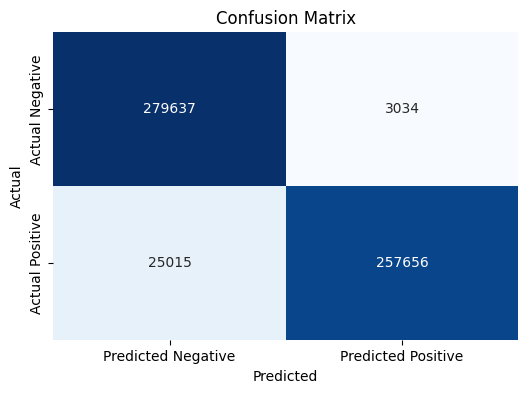

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95    282671
         1.0       0.99      0.91      0.95    282671

    accuracy                           0.95    565342
   macro avg       0.95      0.95      0.95    565342
weighted avg       0.95      0.95      0.95    565342



In [18]:
# @title Random Forest Classifier dengan data feature logistik
X_train_ = X_smote_log
y_train_ = y_smote_log

# Disini saya melakukan training keseluruh data Train dengan K-Fold
random = RandomForestClassifier(criterion ='gini', n_estimators= 100, max_depth=50, random_state=42)
random.fit(X_train_,y_train_)
y_pred_ = cross_val_predict(random, X_train_, y_train_, cv=7)

# Menghitung Confusion Matrik
cm = confusion_matrix(y_train_,y_pred_)
print('Confusion MatriX:\n',cm)

plt.figure(figsize=( 6 ,4 ))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Menghitung Classification Report untuk metrik lainnya
cr = classification_report(y_train_, y_pred_)
print('Classification Report:\n',cr)

ROC AUC Score: 0.9709960574205228


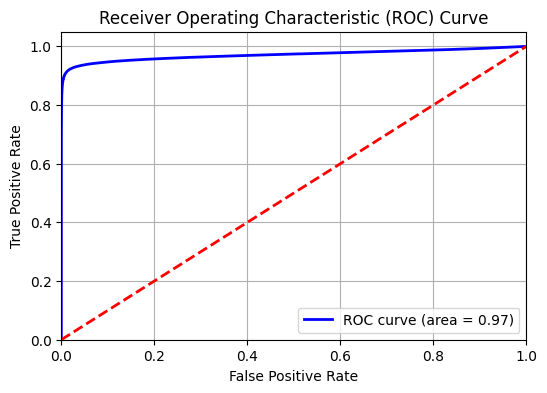

In [19]:
# @title Menampilkan Kurva ROC
# Menghitung probabilitas prediksi untuk kelas positif
y_proba_ = cross_val_predict(random, X_train_, y_train_, cv=7, method='predict_proba')[:, 1]

# Menghitung ROC AUC score
roc_auc = roc_auc_score(y_train_, y_proba_)
print('ROC AUC Score:', roc_auc)
fpr, tpr, thresholds = roc_curve(y_train_, y_proba_)

# Plotting Kurva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Memperbaiki kesalahan sintaks
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Confusion MatriX:
 [[282663      8]
 [ 24840 257831]]


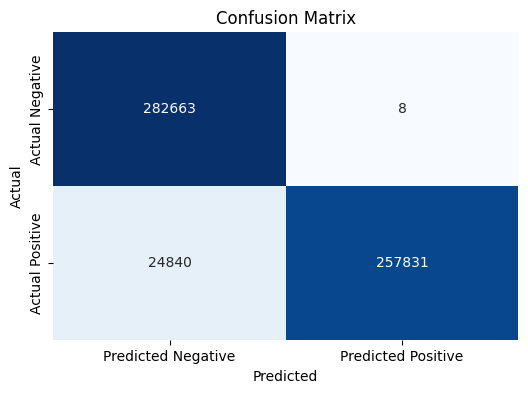

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    282671
         1.0       1.00      0.91      0.95    282671

    accuracy                           0.96    565342
   macro avg       0.96      0.96      0.96    565342
weighted avg       0.96      0.96      0.96    565342



In [20]:
# @title Random Forest Classifier tanpa seleksi feature
X_train = X_smote
y_train = y_smote

# Disini saya melakukan training keseluruh data Train dengan K-Fold
random = RandomForestClassifier(criterion ='gini', n_estimators= 100, max_depth=50, random_state=42)
random.fit(X_train,y_train)
y_pred = cross_val_predict(random, X_train, y_train, cv=7)

# Menghitung Confusion Matrik
cm = confusion_matrix(y_train,y_pred)
print('Confusion MatriX:\n',cm)

plt.figure(figsize=( 6 ,4 ))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Menghitung Classification Report untuk metrik lainnya
cr = classification_report(y_train, y_pred)
print('Classification Report:\n',cr)

ROC AUC Score: 0.9648574986341464


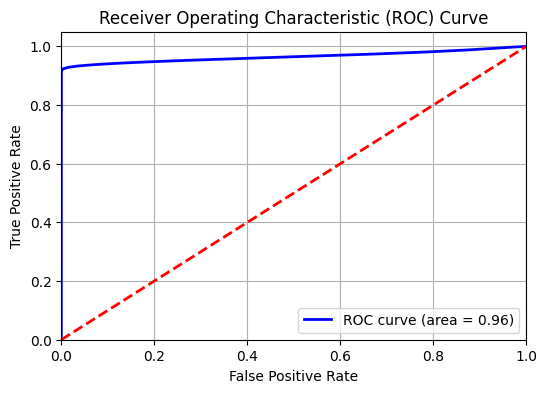

In [21]:
# @title Menampilkan Kurva ROC
# Menghitung probabilitas prediksi untuk kelas positif
y_proba = cross_val_predict(random, X_train, y_train, cv=7, method='predict_proba')[:, 1]

# Menghitung ROC AUC score
roc_auc = roc_auc_score(y_train, y_proba)
print('ROC AUC Score:', roc_auc)
fpr, tpr, thresholds = roc_curve(y_train, y_proba)

# Plotting Kurva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Memperbaiki kesalahan sintaks
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

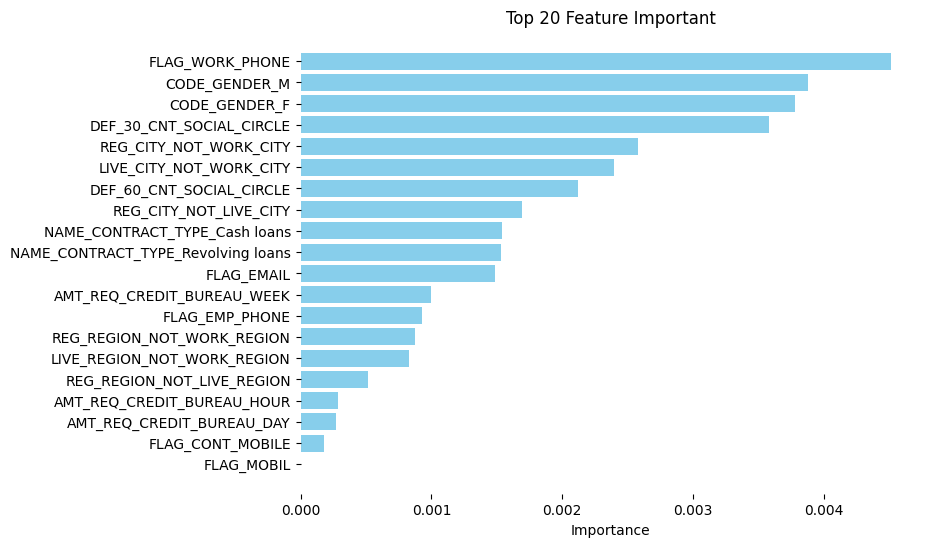

In [39]:
# @title Feature Important Random Forest Classifier
feature_names = [col for col in df_scaler.columns if col not in ['TARGET', 'Target']]

# Get feature importances from the random forest classifier
feature_importances = random.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

# Top 10 Feature Important
top_10_feature_important = feature_importances_df.head(20)
plt.figure(figsize=(8,6))
plt.barh(top_10_feature_important['Feature'], top_10_feature_important['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Important')
plt.gca().spines[['right','bottom','top','left']].set_visible(False)
plt.show()

In [ ]:
'''
  Hasil feature important akan jadi pertimbangan untuk pembuat streamlit
'''